# 1. Autocorrelation

'babies.zip` contains baby name frequencies per year (one file per year). You can treat each baby name as a time series.

1. Get the autocorrelation and partial autocorrelation for the names `Olivia`, `Newton` and `John`.

2. Which name do you expect to be the most popular in 2022? Use an ARIMA model and backtesting to pick 3 interesting candidates. Support your findings with a plot

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
import io
import requests
import zipfile
r = '/Users/kalebmckenzie/Documents/GitHub/5-5-time-series/data/babies.zip'
zipfile.ZipFile(r).extractall('babies')

In [153]:
files = [file for file in os.listdir('babies')
         if file.startswith('yob')]

years = np.array(sorted([int(file[3:7])
                         for file in files]))

data = {year:
        pd.read_csv('babies/yob%d.txt' % year,
                    index_col=0, header=None,
                    names=['First name',
                           'Gender',
                           'Number'])
        for year in years}

In [154]:
def get_value(name, gender, year):
    """Return the number of babies born a given year,
    with a given gender and a given name."""
    dy = data[year]
    try:
        return dy[dy['Gender'] == gender] \
                 ['Number'][name]
    except KeyError:
        return 0

def get_evolution(name, gender):
    """Return the evolution of a baby name over
    the years."""
    return np.array([get_value(name, gender, year)
                     for year in years])



# 1.

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

In [6]:
def autocorr_name(name, gender, color, axes=None):
    x = get_evolution(name, gender)
    z = autocorr(x)

    # Autocorrelation.
    axes.plot(z / float(z.max()),
                 '-' + color, label=name)
    axes.legend()
    axes.set_title("Autocorrelation")

In [8]:
def partialcorr(name, gender):
    x = get_evolution(name,gender)
    z = plot_pacf(x, lags=20)

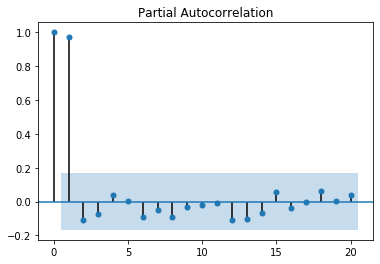

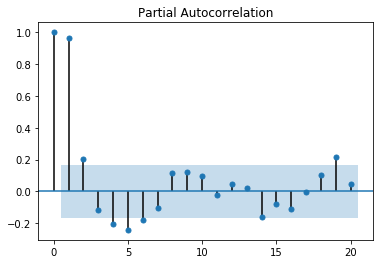

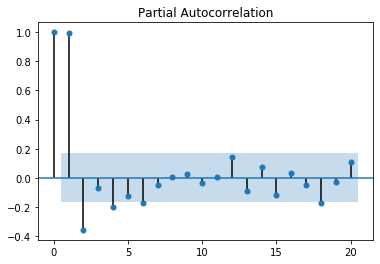

In [9]:
from statsmodels.graphics.tsaplots import plot_pacf
partialcorr('Olivia', 'F')
partialcorr('Newton', 'M')
partialcorr('John', 'M')

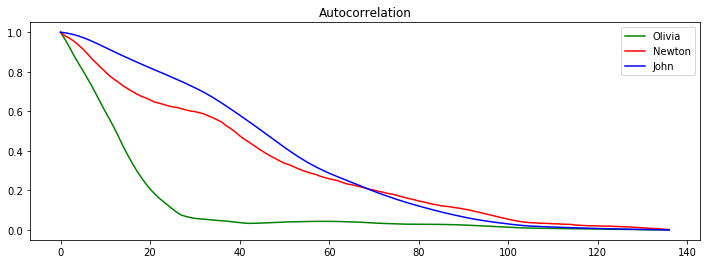

In [10]:
fig, axes = plt.subplots(1, figsize=(12, 4))
autocorr_name('Olivia', 'F', 'g', axes=axes)
autocorr_name('Newton', 'M', 'r', axes=axes)
autocorr_name('John', 'M', 'b', axes=axes)

# 1.2

In [ ]:
"""
Checking most popular names, picking 3 interesting ones.
Then creating a function that gives me a df of the name and their numbers
I then create another function testing stationarity
and one to give me ts_dff_exp

Then it was just a matter of playing with the arima model
"""

In [227]:
from statsmodels.tsa.arima_model import ARIMA
df1 = data[2011].sort_values('Number', ascending=False).head(10)
df1['year'] = 2011

df2 = data[2012].sort_values('Number', ascending=False).head(10)
df2['year'] = 2012
df3 = data[2013].sort_values('Number', ascending=False).head(10)
df3['year'] = 2013

df4 = data[2014].sort_values('Number', ascending=False).head(10)
df4['year'] = 2014

df5 = data[2015].sort_values('Number', ascending=False).head(10)
df5['year'] = 2015

df6 = data[2016].sort_values('Number', ascending=False).head(10)
df6['year'] = 2016

df = df1.append([df2,df3,df4,df5,df6])

In [228]:
df['year'] = pd.to_datetime(df['year'], format='%Y')

In [229]:
df.reset_index(inplace=True)

In [230]:
df = df.set_index('year')

In [222]:
def get_evolution_df(name, gender):

    df = pd.DataFrame([get_value(name, gender, year)
                     for year in years], index=years, columns=[name])
    return df

In [244]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [245]:
def stationarity(name, gender):
    x = get_evolution_df(name, gender)
    z = test_stationarity(x)

    ts_log = np.log(x)
    ts_smooth = ts_log.rolling(window = 12).mean()

    no_sub_ts = ts_smooth
    no_sub_ts.dropna(inplace = True)

    sub_ts = ts_log - ts_smooth
    sub_ts.dropna(inplace = True)

    expwighted_avg = ts_log.ewm(halflife=12).mean()

    exp_ts_diff = ts_log-expwighted_avg

    ts_diff = ts_log - ts_log.shift()
    ts_diff.dropna(inplace = True)

    ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
    ts_diff_exp.dropna(inplace = True)

    return test_stationarity(ts_diff_exp)


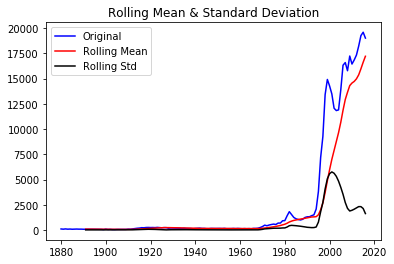

Results of Dickey-Fuller Test:


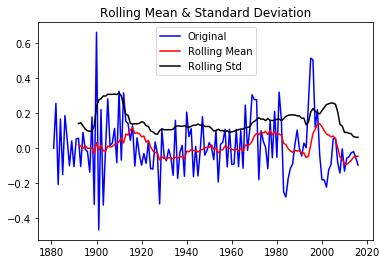

Results of Dickey-Fuller Test:
Test Statistic                -5.778030e+00
p-value                        5.204021e-07
#Lags Used                     1.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


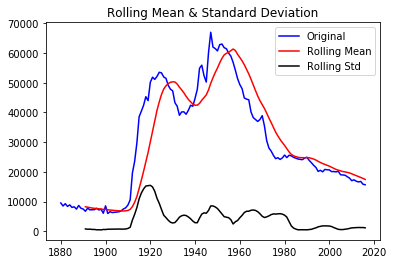

Results of Dickey-Fuller Test:


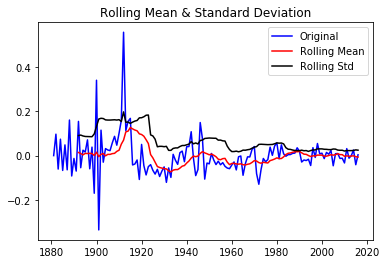

Results of Dickey-Fuller Test:
Test Statistic                  -3.050075
p-value                          0.030475
#Lags Used                      12.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


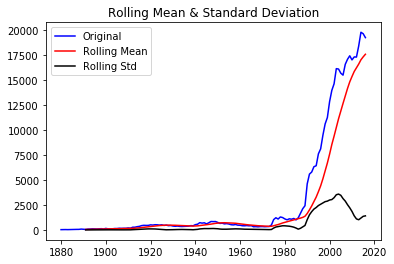

Results of Dickey-Fuller Test:


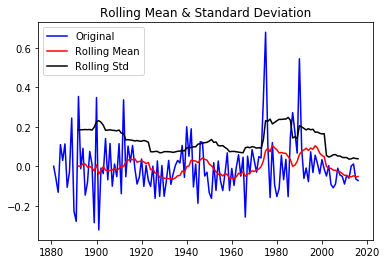

Results of Dickey-Fuller Test:
Test Statistic                -7.119926e+00
p-value                        3.745516e-10
#Lags Used                     1.000000e+00
Number of Observations Used    1.340000e+02
Critical Value (1%)           -3.480119e+00
Critical Value (5%)           -2.883362e+00
Critical Value (10%)          -2.578407e+00
dtype: float64


In [251]:
ts1 = stationarity('Noah', 'M')
print(ts1)
ts2 = stationarity('William', 'M')
print(ts2)
ts3 = stationarity('Olivia', 'F')
print(ts3)

In [292]:
def stationarity_df(name, gender):
    x = get_evolution_df(name, gender)


    ts_log = np.log(x)
    ts_smooth = ts_log.rolling(window = 12).mean()

    no_sub_ts = ts_smooth
    no_sub_ts.dropna(inplace = True)

    sub_ts = ts_log - ts_smooth
    sub_ts.dropna(inplace = True)

    expwighted_avg = ts_log.ewm(halflife=12).mean()

    exp_ts_diff = ts_log-expwighted_avg

    ts_diff = ts_log - ts_log.shift()
    ts_diff.dropna(inplace = True)

    ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
    ts_diff_exp.dropna(inplace = True)

    return ts_diff_exp


In [293]:
name1 = stationarity_df('Noah', 'M')
name2 = stationarity_df('William', 'M')
name3 = stationarity_df('Olivia', 'F')

In [294]:
name1['year'] = pd.to_datetime(name1.index, format='%Y')
name2['year'] = pd.to_datetime(name2.index, format='%Y')
name3['year'] = pd.to_datetime(name3.index, format='%Y')

In [295]:
name1.reset_index(inplace=True)
name2.reset_index(inplace=True)
name3.reset_index(inplace=True)

In [296]:
name1 = name1.set_index('year')
name2 = name2.set_index('year')
name3 = name3.set_index('year')

In [298]:
name1 = name1.drop(['index'], axis=1)
name2 = name2.drop(['index'], axis=1)
name3 = name3.drop(['index'], axis=1)

In [302]:
df_name1 = name1.tail(30)
df_name2 = name2.tail(30)
df_name3 = name3.tail(30)

In [306]:
df_train1 = df_name1.iloc[:-6]
df_test1 = df_name1.iloc[-6:]

df_train2 = df_name2.iloc[:-6]
df_test2 = df_name2.iloc[-6:]

df_train3 = df_name3.iloc[:-6]
df_test3 = df_name3.iloc[-6:]

/Users/kalebmckenzie/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


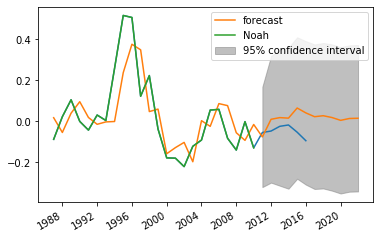

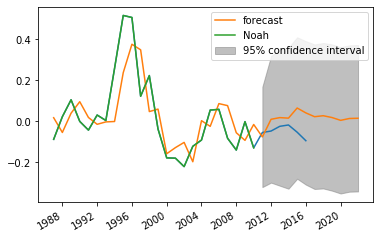

In [314]:
from statsmodels.tsa.arima_model import ARIMA

#Arima for name Noah

model = ARIMA(df_train1, order=(7, 0, 0))  
res = model.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(df_name1)

res.plot_predict('1987', '2022', ax=ax)

/Users/kalebmckenzie/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


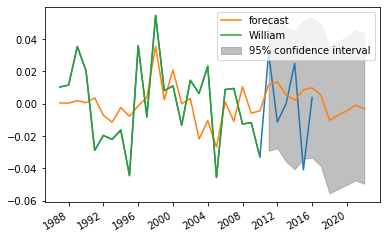

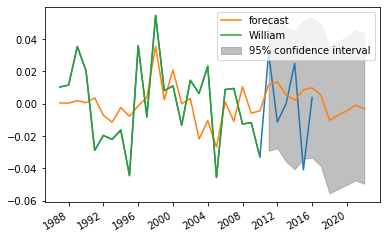

In [315]:
#Arima for name William

model2 = ARIMA(df_train2, order=(7, 0, 0))  
res2 = model2.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(df_name2)

res2.plot_predict('1987', '2022', ax=ax)

/Users/kalebmckenzie/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


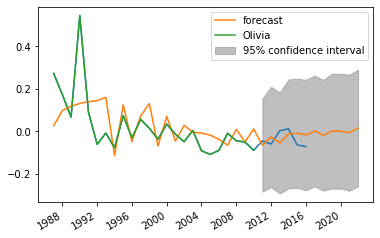

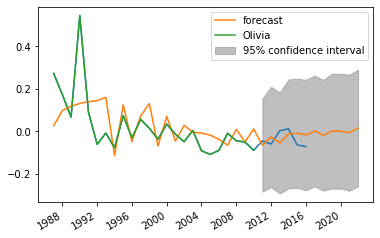

In [316]:
#Arima for name Olivia

model3 = ARIMA(df_train3, order=(7, 0, 0))  
res3 = model3.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(df_name3)

res3.plot_predict('1987', '2022', ax=ax)

# 2. Counterfactual prediction testing

The [FRED](https://fred.stlouisfed.org) database has economic data useful for this question.

A common method to test the effect of a one-off event is to fit an ARIMA model up to the event, and compare the forecast to the actual data of what happened, then measure the gap between the forecast and the event data.

1. Use GDP and unemployment data with the Counterfactual prediction testing methodology to get an estimate of the magnitude of COVID (around March 2020 as a cutoff date) on these two statistics. Use an ARIMA model which fits best to the pre-COVID time series and compare the output of both. Provide a visualization.

2. Is GDP a unit root process or trend stationary? Use the 2008 and 2020 GDP shocks and statistical tests we've seen in class to provide an argument (it's possible event one says one thing and the other event says the opposite).

In [40]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff

# 2.1

# GDP 2.1

In [86]:
gdpdf = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/5-5-time-series/data/GDP.csv',index_col='DATE', parse_dates=True)

gdpdf.index.freq = 'QS'


In [323]:
def stationarity_gdp(series):


    ts_log = np.log(series)
    ts_smooth = ts_log.rolling(window = 12).mean()

    no_sub_ts = ts_smooth
    no_sub_ts.dropna(inplace = True)

    sub_ts = ts_log - ts_smooth
    sub_ts.dropna(inplace = True)

    expwighted_avg = ts_log.ewm(halflife=12).mean()

    exp_ts_diff = ts_log-expwighted_avg

    ts_diff = ts_log - ts_log.shift()
    ts_diff.dropna(inplace = True)

    ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
    ts_diff_exp.dropna(inplace = True)

    return ts_diff_exp

In [324]:
gdp_df = stationarity_gdp(gdpdf)

In [337]:
gdp_df1 = pd.DataFrame(gdp_df.loc['1999-01-01': '2020-03-01'])

In [340]:
train = gdp_df1.iloc[:-17]
test = gdp_df1.iloc[-17:]

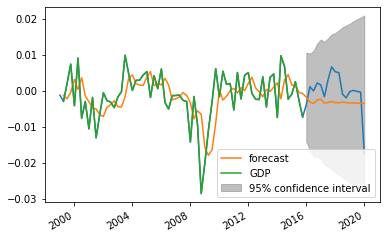

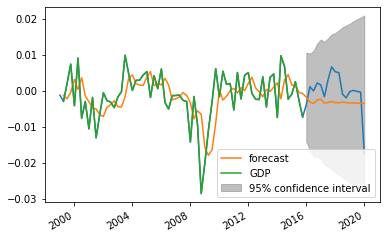

In [343]:
model_gdp = ARIMA(train, order=(7, 1, 0))  
res_gdp = model_gdp.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(gdp_df1)

res_gdp.plot_predict('1999', '2020', ax=ax)

# Unemployment 2.1

In [345]:
uedf = pd.read_csv('/Users/kalebmckenzie/Documents/GitHub/5-5-time-series/data/UNRATE(1).csv',index_col='DATE', parse_dates=True)

In [344]:
def stationarity_ue(series):


    ts_log = np.log(series)
    ts_smooth = ts_log.rolling(window = 12).mean()

    no_sub_ts = ts_smooth
    no_sub_ts.dropna(inplace = True)

    sub_ts = ts_log - ts_smooth
    sub_ts.dropna(inplace = True)

    expwighted_avg = ts_log.ewm(halflife=12).mean()

    exp_ts_diff = ts_log-expwighted_avg

    ts_diff = ts_log - ts_log.shift()
    ts_diff.dropna(inplace = True)

    ts_diff_exp = ts_diff  - ts_diff.ewm(halflife = 12).mean()
    ts_diff_exp.dropna(inplace = True)

    return ts_diff_exp

In [349]:
ue_df1 = pd.DataFrame(ue_df.loc['1999-01-01': '2020-03-01'])

In [346]:
ue_df = stationarity_ue(uedf)

In [356]:
train_ue = ue_df1.iloc[:-51]
test_ue = ue_df1.iloc[-51:]

/Users/kalebmckenzie/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/kalebmckenzie/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


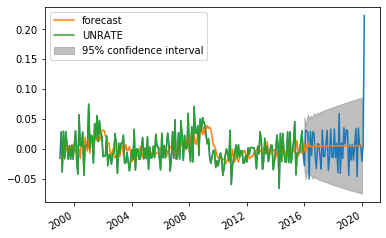

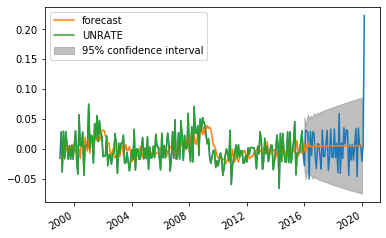

In [357]:
model_ue = ARIMA(train_ue, order=(7, 1, 0))  
res_ue = model_ue.fit(disp=-1)

fig, ax = plt.subplots()
ax.plot(ue_df1)

res_ue.plot_predict('1999', '2020', ax=ax)